In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Introduction tot data assimilation
## Practical session Day 2 : Tangent and adjoint models

### D2.1 : Tangent model and parameter estimation (logistic model)

We consider the following ODE that models the logistic growth of a population:
\begin{array}{lr}
y'(t)=\alpha y(t)(1-y(t)/K),& t\in[0,T],\\
y(t=0)=y_0,& t=0.
\end{array}
for some given constants $\alpha>0$ and $K>0$. The initial population is $y_0>0$.
In this exercise we  fix the time interval [0,T] = [0,200]. The values of $y$ are computed on 1000 points equally spaced in this interval (option $t\_eval$ of $t\_solve_{ivp}$).


- Compute the derivatives wrt the parameters $\alpha, K, y_0$. Implement a function Dy that takes as input $\alpha, K, y_0$ and as output the Jacobian matrix of $y$ wrt these 3 parameters. Check the validity of this function using finite differences.

- Fix some values $\theta^*=(\alpha^*, K^*, y_0^*)$ close to $(0.1, 10^4, 1)$ up to a factor of e.g. 10. Compute the solution $y(\theta^*)$ and add gaussian noise to generate the observations. (Note: here the observation operator $L$ is the identity operator).\\
Implement the Gauss-Newton algorithm to estimate the parameters with an initial guess that is not close from $\theta^*$.

- Perform the same study with a reduced number of observations points (100, then 10, then smaller values)

In [3]:
parameters = {'alpha':0.1, 'K':1e4}

In [4]:
def logistic(t,y,alpha,K):
    return alpha*y*(1-y/K)


def lDl(t,Y,alpha,K):  
    y = Y[0]
    z1 = Y[1]
    z2 = Y[2]
    z3 = Y[3]
    dty = alpha*y*(1-y/K)
    dtz1 = y*(1-y/K) + alpha*z1*(1-y/K) + alpha*y*(-z1/K)
    dtz2 = alpha*z2*(1-y/K) + alpha*y*(-z2/K) + alpha*y**2/K**2
    dtz3 = alpha*z3*(1-y/K) + alpha*y*(-z3/K)
    return np.array([dty, dtz1, dtz2, dtz3])


def yDy(alpha,K,y0):
    # solve the ODE and the 3 tangent models
    sol = solve_ivp(lDl,[0,T],[y0,0,0,1],t_eval=timepoints,args=(alpha,K),rtol = 1e-10)
    return sol.y

0.01 0.17491425672658864
0.0001 0.001769089974026785
1e-06 1.7692882617725908e-05
1e-08 1.7801769522666539e-07
1e-10 2.4264865646873354e-07
1e-12 1.9040043867184788e-05
0 [8.79619906e-02 5.03188548e+04 1.33049276e+01]
[2.14167602e+14 3.75764951e+02]
1 [8.07959837e-02 4.20226384e+04 1.33049276e+01]
[1.84555421e+14 3.31425751e+02]
2 [7.97552902e-02 4.23501566e+04 1.33049276e+01]
[1.95245607e+14 3.22297086e+02]
3 [7.97701767e-02 4.23599706e+04 1.33049276e+01]
[1.95237775e+14 3.22408557e+02]
4 [7.97701569e-02 4.23599788e+04 1.33049276e+01]
[1.95238005e+14 3.22408378e+02]
5 [7.97701569e-02 4.23599788e+04 1.33049276e+01]
[1.95238004e+14 3.22408378e+02]
6 [7.97701569e-02 4.23599788e+04 1.33049276e+01]
[1.95238004e+14 3.22408378e+02]
7 [7.97701569e-02 4.23599788e+04 1.33049276e+01]
[1.95238004e+14 3.22408378e+02]
8 [7.97701569e-02 4.23599788e+04 1.33049276e+01]
[1.95238004e+14 3.22408378e+02]
9 [7.97701569e-02 4.23599788e+04 1.33049276e+01]
[1.95238004e+14 3.22408378e+02]
10 [7.97701569e-02 4.

Text(0.5, 1.0, 'Evolution of the cost function')

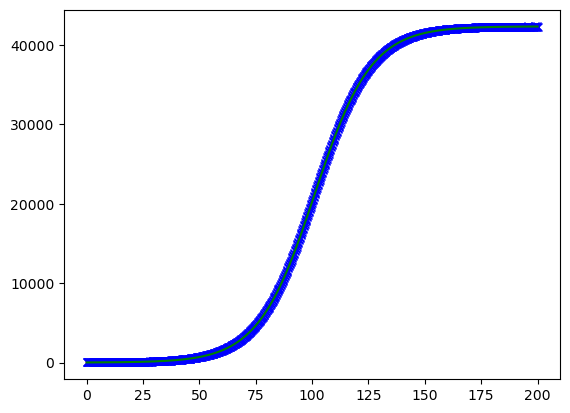

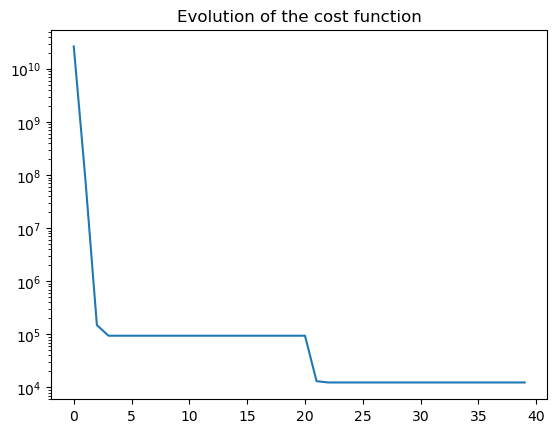

In [6]:
T = 200
numpoints = 1000
timepoints = np.linspace(0,T,numpoints)

alpha0 = parameters['alpha']
K0 = parameters['K']
Y = yDy(alpha0, K0, 1.0)
Jacobian = Y[1:4,:].transpose()

#%%########## check for the derivatives
h = np.random.randn(3)
for epsilon in [1e-2, 1e-4, 1e-6, 1e-8, 1e-10, 1e-12]:    
    Yh = yDy(alpha0+epsilon*h[0], K0+epsilon*h[1], 1+epsilon*h[2])
    difdiv = 1/epsilon * (Yh[0,:]-Y[0,:])
    product_jac = np.dot(Jacobian,h)
    reldifference = np.linalg.norm(difdiv-product_jac)/np.linalg.norm(difdiv)
    print(epsilon,reldifference)

#%%############# parameters estimation
alphatrue = 0.08
Ktrue = 42350
y0true = 13

Ytrue = yDy(alphatrue, Ktrue, y0true)
noiselevel = 5
yobs = Ytrue[0,:] + noiselevel*np.random.randn(numpoints)

fig, ax = plt.subplots()
ax.plot(timepoints,Ytrue[0,:],'r')
ax.plot(timepoints,yobs,'bx')

precision = 0.2

alphaini = alphatrue*(1-precision+2*precision*np.random.rand())
Kini = Ktrue*(1-precision+2*precision*np.random.rand())
y0ini = y0true*(1-precision+2*precision*np.random.rand())
paramk = np.array([alphaini, Kini, y0ini])
nbit = 20
Jlist = []

y0ini = y0true
for it in range(nbit): # update only alpha and K - not y0

    print(it, paramk)
    Y = yDy(paramk[0], paramk[1], paramk[2])
    yk = Y[0,:]
    F = yk - yobs
    Jlist.append(0.5*np.linalg.norm(yk-yobs)**2)
    DF = Y[1:3,:].transpose()
    DFTF = np.dot(DF.transpose(),F)
    DFTDF = np.dot(DF.transpose(),DF)
    u,s,v = np.linalg.svd(DFTDF)
    print(s)
    dk = np.linalg.solve(DFTDF, -DFTF)
    paramk[:2] = paramk[:2] + 1*dk\


for it in range(nbit):
    print(it, paramk)
    Y = yDy(paramk[0], paramk[1], paramk[2])
    yk = Y[0,:]
    F = yk - yobs
    Jlist.append(0.5*np.linalg.norm(yk-yobs)**2)
    DF = Y[1:4,:].transpose()
    DFTF = np.dot(DF.transpose(),F)
    DFTDF = np.dot(DF.transpose(),DF)
    u,s,v = np.linalg.svd(DFTDF)
    print(s)
    dk = np.linalg.solve(DFTDF+0.0*np.max(s)*np.eye(3), -DFTF)
    paramk = paramk + 1*dk
    
ax.plot(timepoints,yk,'g')


fig, ax = plt.subplots()
ax.semilogy(Jlist)
ax.set_title('Evolution of the cost function');